Dataset shape: (1910269, 8)
Columns: Index(['DateTime', 'Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'],
      dtype='object')

Missing values per column:
 DateTime                     0
Global_active_power      13515
Global_reactive_power    13516
Voltage                  13516
Global_intensity         13516
Sub_metering_1           13516
Sub_metering_2           13516
Sub_metering_3           13516
dtype: int64

Weekly data shape: (191, 2)
    DateTime  Weekly_Consumption
0 2006-12-17            4599.636
1 2006-12-24           17477.128
2 2006-12-31           19736.518
3 2007-01-07           14961.068
4 2007-01-14           16176.334


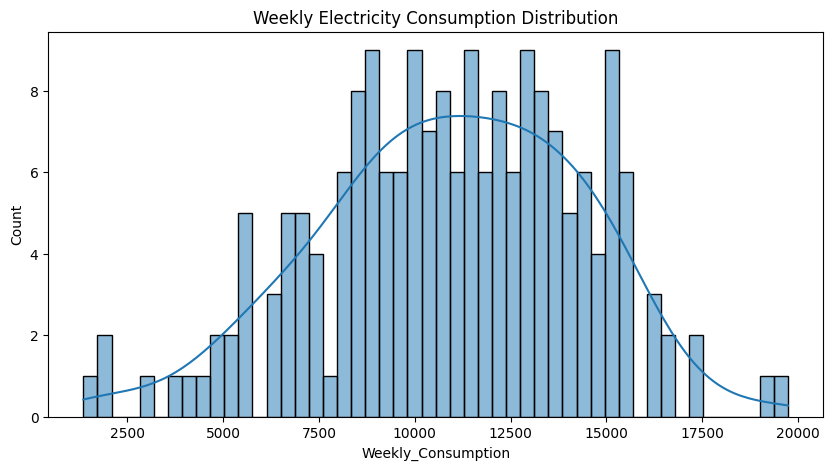


Years available in dataset: [2006 2007 2008 2009 2010]

Train + Validation Set: (159, 7), Test Set: (32, 7)

Scaled features for training (first 5 rows):
 [[-2.29959466  1.53752887  0.13575883  0.          0.        ]
 [-2.29959466  1.53752887  0.93101977  0.          0.        ]
 [-2.29959466  1.53752887  1.7262807   0.          0.        ]
 [-1.12768584 -1.62988927 -1.00032822  0.          0.        ]
 [-1.12768584 -1.62988927 -0.20506729  0.          0.        ]]

MSE per fold: [27963048.38208686  3936608.23711191 10167792.1158345   4390574.95901339
  4713447.49212146]
Average MSE across folds: 10234294.237233626

✅ Test RMSE: 1948.33


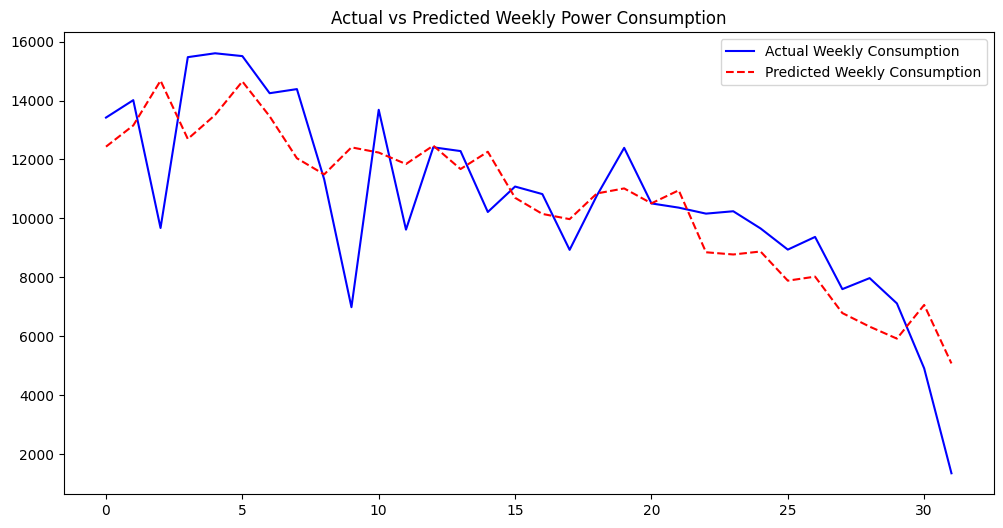

In [4]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, make_scorer
from xgboost import XGBRegressor


data = pd.read_csv(
    '/content/household_power_consumption.txt',
    sep=';',
    parse_dates={'DateTime': ['Date', 'Time']},
    infer_datetime_format=True,
    na_values='?'
)

print("Dataset shape:", data.shape)
print("Columns:", data.columns)
print("\nMissing values per column:\n", data.isnull().sum())


cols = [
    'Global_active_power', 'Global_reactive_power', 'Voltage',
    'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3'
]


data[cols] = data[cols].astype(float)
data.dropna(inplace=True)


data.set_index('DateTime', inplace=True)
weekly_data = data['Global_active_power'].resample('W').sum().reset_index()
weekly_data.rename(columns={'Global_active_power': 'Weekly_Consumption'}, inplace=True)

print("\nWeekly data shape:", weekly_data.shape)
print(weekly_data.head())


weekly_data['Year'] = weekly_data['DateTime'].dt.year
weekly_data['Month'] = weekly_data['DateTime'].dt.month
weekly_data['Day'] = weekly_data['DateTime'].dt.day
weekly_data['DayOfWeek'] = weekly_data['DateTime'].dt.dayofweek
weekly_data['IsWeekend'] = weekly_data['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)


plt.figure(figsize=(10,5))
sns.histplot(weekly_data['Weekly_Consumption'], bins=50, kde=True)
plt.title("Weekly Electricity Consumption Distribution")
plt.show()


print("\nYears available in dataset:", weekly_data['Year'].unique())
last_year = weekly_data['Year'].max()

test = weekly_data[weekly_data['Year'] == last_year]
train_val = weekly_data[weekly_data['Year'] < last_year]

print(f"\nTrain + Validation Set: {train_val.shape}, Test Set: {test.shape}")


X_train_val = train_val.drop(['Weekly_Consumption', 'DateTime'], axis=1)
y_train_val = train_val['Weekly_Consumption']
X_test = test.drop(['Weekly_Consumption', 'DateTime'], axis=1)
y_test = test['Weekly_Consumption']


scaler = StandardScaler()
X_train_val = scaler.fit_transform(X_train_val)
X_test = scaler.transform(X_test)

print(f"\nScaled features for training (first 5 rows):\n {X_train_val[:5]}")


tscv = TimeSeriesSplit(n_splits=5)
model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

mse_scorer = make_scorer(mean_squared_error)
cv_scores = cross_val_score(model, X_train_val, y_train_val, cv=tscv, scoring=mse_scorer)

print(f"\nMSE per fold: {cv_scores}")
print(f"Average MSE across folds: {cv_scores.mean()}")


model.fit(X_train_val, y_train_val)
y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"\n✅ Test RMSE: {rmse:.2f}")


plt.figure(figsize=(12,6))
plt.plot(y_test.values, label="Actual Weekly Consumption", color='blue')
plt.plot(y_pred, label="Predicted Weekly Consumption", color='red', linestyle='dashed')
plt.title("Actual vs Predicted Weekly Power Consumption")
plt.legend()
plt.show()
